In [1]:
import equinox as eqx
import jax
import optax
import jax.numpy as jnp
from jaxtyping import Float, Int, Array

@eqx.filter_jit
def loss(
    net: eqx.Module, batch: Float[Array, "batch 3 28 28"], labels: Int[Array, " batch"]
) -> Float[Array, ""]:
    """Compute the loss of the network on a batch of data."""
    batch_size = batch.shape[0]
    batched_keys = jax.random.split(key, num=batch_size)

    logits = jax.vmap(net, in_axes=(0, 0))(batch, batched_keys)

    one_hot_labels = jax.nn.one_hot(labels, 10)

    # optax also provides a number of common loss functions.
    loss_per_sample = optax.softmax_cross_entropy(logits, one_hot_labels)

    aux = {
        "loss": jnp.mean(loss_per_sample),
        "accuracy": jnp.mean(jnp.argmax(logits, axis=-1) == labels),
        "top_5_accuracy": jnp.mean(
            jnp.sum(jnp.argsort(logits, axis=-1)[:, -5:] == labels[:, None], axis=-1)
        ),
        "loss_per_sample": loss_per_sample,
    }
    return jnp.mean(loss_per_sample), aux

In [2]:
import torch

def evaluate(model: eqx.Module, testloader: torch.utils.data.DataLoader):
    """This function evaluates the model on the test dataset,
    computing both the average loss and the average accuracy.
    """
    avg_loss = 0
    avg_acc = 0
    avg_top_5_acc = 0
    sample_losses = []
    for x, y in testloader:
        x = x.numpy()
        y = y.numpy()
        # Note that all the JAX operations happen inside `loss` and `compute_accuracy`,
        # and both have JIT wrappers, so this is fast.
        out_loss, aux = loss(model, x, y)
        avg_loss += out_loss
        avg_acc += aux["accuracy"]
        avg_top_5_acc += aux["top_5_accuracy"]

        sample_losses.append(aux["loss_per_sample"])

    return avg_loss / len(testloader), avg_acc / len(testloader), avg_top_5_acc / len(testloader), sample_losses

In [3]:
import time

from jaxtyping import PyTree
from generalization.models import get_cifar_models
from typing import Any, Dict, Union
from fastprogress.fastprogress import master_bar, progress_bar


def init_metrics() -> Dict[str, Any]:
    return {
        "train_loss": [],
        "train_accuracy": [],
        "test_loss": [],
        "test_accuracy": [],
        "test_top_5_accuracy": [],
        "train_sample_losses": [],
        "test_sample_losses": [],
        "train_epoch_time": [],
        "test_epoch_time": [],
    }


def update_metrics(
    train: bool,
    metrics: Dict[str, Any],
    loss,
    acc,
    loss_per_sample,
    epoch_time: float,
    top_5_acc=None,
    trainloader_size=None,
):
    if train:
        metrics["train_loss"].append(loss / trainloader_size)
        metrics["train_accuracy"].append(acc / trainloader_size)
        metrics["train_sample_losses"].append(loss_per_sample)
        metrics["train_epoch_time"].append(epoch_time)
    else:
        metrics["test_loss"].append(loss)
        metrics["test_accuracy"].append(acc)
        metrics["test_top_5_accuracy"].append(top_5_acc)
        metrics["test_sample_losses"].append(loss_per_sample)
        metrics["test_epoch_time"].append(epoch_time)


def init_bar(epochs, metrics) -> master_bar:
    mbar = master_bar(range(epochs))
    mbar.names = ["epoch"]
    for name in metrics:
        # filter per-sample metrics
        if "sample" in name:
            continue
        mbar.names.append(name)
    mbar.write(mbar.names, table=True)
    return mbar


def update_mbar(epoch, metrics, mbar):
    update = [epoch]
    update += [f"{metrics[name][-1]:.3f}" for name in mbar.names[1:]]
    mbar.write(update, table=True)


def train(
    model: eqx.Module,
    trainloader: torch.utils.data.DataLoader,
    testloader: torch.utils.data.DataLoader,
    optim: optax.GradientTransformation,
    epochs: int,
    print_every: int,
) -> Union[eqx.Module, Dict[str, Any]]:
    # Just like earlier: It only makes sense to train the arrays in our model,
    # so filter out everything else.
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    # Always wrap everything -- computing gradients, running the optimiser, updating
    # the model -- into a single JIT region. This ensures things run as fast as
    # possible.
    @eqx.filter_jit
    def make_step(
        model: eqx.Module,
        opt_state: PyTree,
        x: Float[Array, "batch 3 28 28"],
        y: Int[Array, " batch"],
    ):
        (loss_value, aux), grads = eqx.filter_value_and_grad(loss, has_aux=True)(
            model, x, y
        )
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value, aux

    metrics = init_metrics()
    mbar = init_bar(epochs=epochs, metrics=metrics)

    start_time = time.time()
    for epoch in mbar:
        start_epoch_time = time.time()
        running_loss = 0.0
        runnning_acc = 0.0
        running_sample_losses = []

        for _, (x, y) in enumerate(progress_bar(trainloader, parent=mbar)):
            # PyTorch dataloaders give PyTorch tensors by default,
            # so convert them to NumPy arrays.
            x = x.numpy()
            y = y.numpy()
            model, opt_state, train_loss, aux = make_step(model, opt_state, x, y)

            running_loss += train_loss.item()
            runnning_acc += aux["accuracy"].item()
            running_sample_losses.append(aux["loss_per_sample"])
        end_epoch_time = time.time()

        update_metrics(
            train=True,
            metrics=metrics,
            loss=running_loss,
            acc=runnning_acc,
            loss_per_sample=running_sample_losses,
            epoch_time=end_epoch_time - start_epoch_time,
            trainloader_size=len(trainloader),
        )

        if (epoch % print_every) == 0 or (epochs == epoch):
            start_test_time = time.time()
            test_loss, test_accuracy, top_5_acc, test_sample_losses = evaluate(
                model, testloader
            )
            end_test_time = time.time()
            update_metrics(
                train=False,
                metrics=metrics,
                loss=test_loss,
                acc=test_accuracy,
                loss_per_sample=test_sample_losses,
                top_5_acc=top_5_acc,
                epoch_time=end_test_time - start_test_time,
            )

        update_mbar(epoch, metrics, mbar)

    print(
        f"Total time: {time.time() - start_time:.3f} s, {(time.time() - start_time)/ 60:.3f} min"
    )
    metrics["total_time"] = time.time() - start_time
    return model, metrics


BATCH_SIZE = 200
LEARNING_RATE = 3e-4
STEPS = 300
PRINT_EVERY = 3
SEED = 5678
EPOCHS = 10

Available corruptions: ['random_labels', 'partial_labels', 'gaussian_pixels', 'random_pixels', 'shuffled_pixels']
Files already downloaded and verified
Files already downloaded and verified
Output Shape: torch.Size([3, 28, 28])


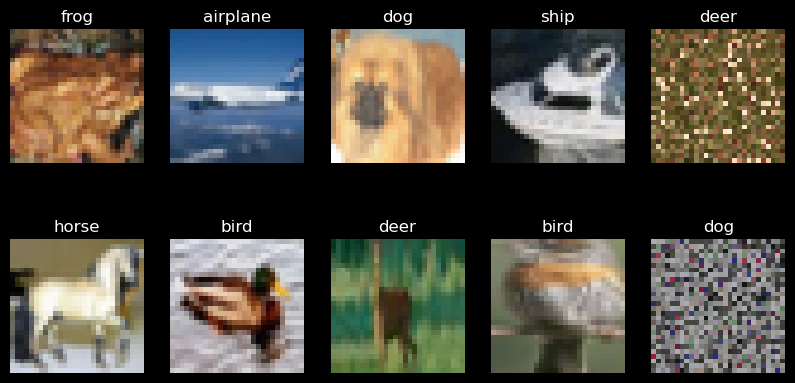

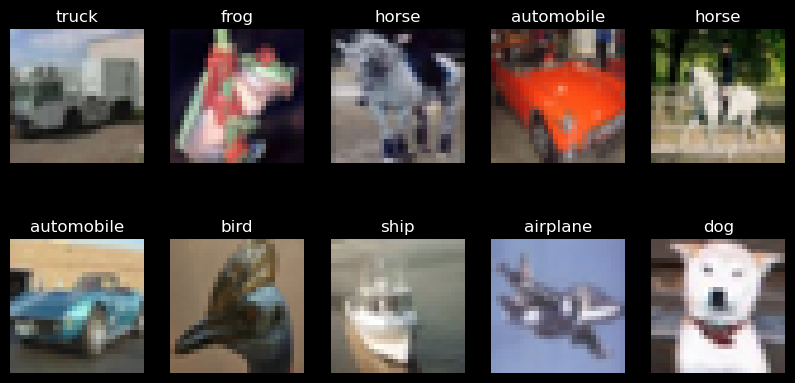

In [4]:
from generalization.randomization import build_cifar10, available_corruptions, get_cifar10_transforms

print("Available corruptions:", available_corruptions())

dsets, train_loader, test_loader = build_cifar10(
    corruption_name="shuffled_pixels", 
    corruption_prob=0.3, 
    batch_size=BATCH_SIZE, 
    show_images=True
)
dsets[0][100]
STEPS = len(train_loader) 

In [5]:
key = jax.random.PRNGKey(SEED)

models = get_cifar_models(key=key)
print(models.keys())
net = models["alexnet"]

dict_keys(['alexnet', 'inception', 'mlp_1x512', 'mlp_3x512'])


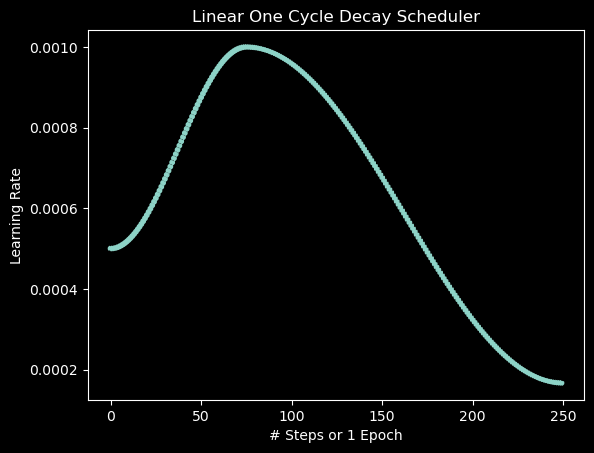

In [6]:
import matplotlib.pyplot as plt

LEARNING_RATE = 1e-3

schedule = optax.cosine_onecycle_schedule(
    transition_steps=STEPS,
    peak_value=LEARNING_RATE,
    pct_start=0.3,
    div_factor=2.0,
    final_div_factor=3.0,
)

lrs = [schedule(i) for i in range(STEPS)]


optim = optax.chain(
    optax.clip(1.0),
    optax.adamw(learning_rate=schedule)
)


plt.scatter(range(STEPS), lrs, s=10, marker="o", linestyle="dashed")
plt.title("Linear One Cycle Decay Scheduler")
plt.ylabel("Learning Rate")
plt.xlabel("# Steps or 1 Epoch")
plt.show()

In [7]:
model, metrics = train(
    net, train_loader, test_loader, optim, epochs=EPOCHS, print_every=1
)

epoch,train_loss,train_accuracy,test_loss,test_accuracy,test_top_5_accuracy,train_epoch_time,test_epoch_time
0,1.799,0.324,1.396,0.482,0.924,17.391,4.717
1,1.504,0.443,1.299,0.522,0.941,11.128,2.035
2,1.408,0.484,1.186,0.573,0.949,11.173,2.021
3,1.322,0.519,1.107,0.598,0.957,11.178,2.028
4,1.234,0.550,1.074,0.617,0.959,11.236,2.007
5,1.170,0.576,0.980,0.646,0.969,11.195,2.015
6,1.104,0.601,0.927,0.675,0.972,11.157,2.023
7,1.041,0.626,0.884,0.694,0.974,11.180,2.022
8,0.988,0.645,0.858,0.700,0.975,11.285,2.024
9,0.946,0.657,0.834,0.706,0.977,11.171,2.035


Total time: 141.029 s, 2.350 min


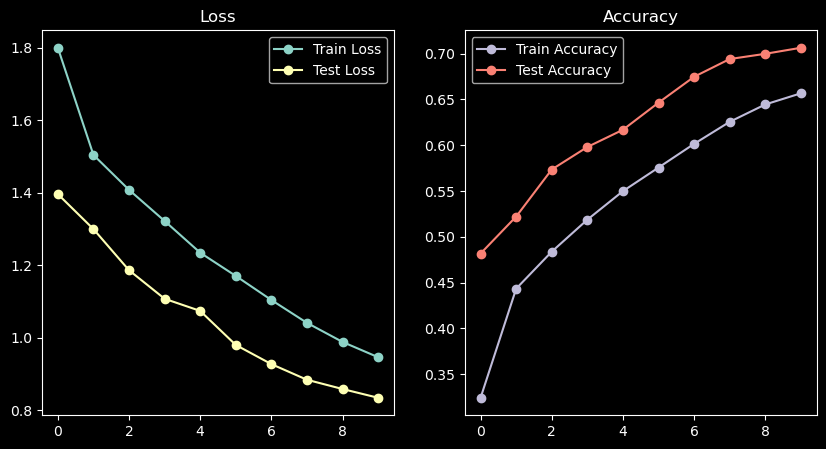

In [33]:
import matplotlib.pyplot as plt


def show_every(train, test, test_every=1, title="Loss", hold=False, fig=None):
    if fig is None:
        fig = plt.figure(figsize=(10, 5))
        # add subplot to the left
        ax = fig.add_subplot(1, 2, 1)
    else:
        # add subplot to the right
        ax = fig.add_subplot(1, 2, 2)
        # force the new plots to use 3rd and 4th colors
        palette = plt.rcParams["axes.prop_cycle"].by_key()["color"]
        ax.set_prop_cycle(color=palette[2:4])

    ax.plot(train, label=f"Train {title}", marker="o")
    if len(test) < len(train):
        test = [test[i // test_every] for i in range(len(train))]
    ax.plot(test, label=f"Test {title}", marker="o")
    ax.legend()
    ax.set_title(title)

    return fig


fig = show_every(
    metrics["train_loss"],
    metrics["test_loss"],
    test_every=PRINT_EVERY,
    title="Loss",
    hold=True,
)
fig = show_every(
    metrics["train_accuracy"],
    metrics["test_accuracy"],
    test_every=PRINT_EVERY,
    title="Accuracy",
    fig=fig,
)

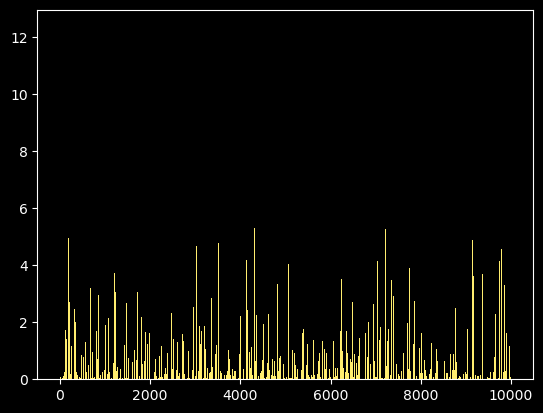

In [12]:
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def animate_per_sample(per_sample: List[List[Float[Array, ""]]], save_path: str = None):
    # make a gif of the a per sample value
    fig = plt.figure()
    ims = []
    for i in range(len(per_sample)):
        # flatten the list of lists
        dset_per_sample = np.array(per_sample[i]).flatten()        
        im = plt.bar(np.arange(len(dset_per_sample)), dset_per_sample)
        ims.append(im)

    ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True)
    ani.save(f"{save_path}.gif")
    return ani

# show gif 
ani = animate_per_sample(metrics["test_sample_losses"], save_path="test_sample_loss")

HTML(ani.to_jshtml())